# Data wrangling on earnings split

## Read data and correct labeles

In [1]:
from pandas import merge as pd_merge,pivot,read_csv,set_option
filename = 'dataset//earnings_split/EAR_4MTH_SEX_ECO_CUR_NB_A-filtered-2021-03-21.csv'
df_field_incomes_columns_csv = ["ref_area.label","classif1.label","classif2.label","time","obs_value"]
df_field_incomes_columns_names = ["Country","Field","Currency","Year","Income"]
df_field_incomes = read_csv(filename,usecols=df_field_incomes_columns_csv)
# take only rows in dollars and drop currency label
df_field_incomes = df_field_incomes[(df_field_incomes["classif2.label"]=="Currency: U.S. dollars") & (df_field_incomes["time"]>2009)].drop("classif2.label", axis=1)
# rename fields
df_field_incomes = df_field_incomes.rename(columns={k:v for k,v in zip(df_field_incomes_columns_csv,df_field_incomes_columns_names)})
# take only one type of total value
df_field_incomes = df_field_incomes[(df_field_incomes["Field"]=="Economic activity (Aggregate): Total") | (~df_field_incomes.Field.str.endswith('Total')) ]
# keep possibly cut too much
df_field_incomes["Field"] = list(map(lambda text: text.split(":")[1][1:],df_field_incomes["Field"]))
df_field_incomes.head(25)

,Country,Field,Year,Income
5,Aruba,"A. Agriculture, hunting and forestry",2010,1221.79
8,Aruba,B. Fishing,2010,1022.35
11,Aruba,C. Mining and quarrying,2010,1463.13
14,Aruba,D. Manufacturing,2010,2031.28
17,Aruba,"E. Electricity, gas and water supply",2010,3022.35
20,Aruba,F. Construction,2010,1390.50
23,Aruba,G. Wholesale and retail trade; repair of motor...,2010,1320.67
26,Aruba,H. Hotels and restaurants,2010,1342.46
29,Aruba,"I. Transport, storage and communications",2010,1872.07
32,Aruba,J. Financial intermediation,2010,2451.96


## Transpose data for more readable results

In [2]:
grupedByYear = [ddd.rename(columns={"Income":str(int(Year))}).drop("Year", axis=1) for Year,ddd in df_field_incomes.groupby("Year")]
from functools import reduce
from pandas import merge as pd_merge
merged_pd = reduce(lambda a,b: pd_merge(a,b, on=["Field", "Country"],how="left"),grupedByYear[:-1])
merged_pd.head()

,Country,Field,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Aruba,"A. Agriculture, hunting and forestry",1221.79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Aruba,B. Fishing,1022.35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Aruba,C. Mining and quarrying,1463.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Aruba,D. Manufacturing,2031.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Aruba,"E. Electricity, gas and water supply",3022.35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Remove rows with too much nulls or replace them with mean value between previous and last year

In [3]:
import numpy as np
def removeNull(df):
    for index, row in df.iterrows():
        null_row = row.isnull()
        nulls_in_row = null_row.sum()
        if nulls_in_row > 1 or np.isnan(row['2010']) or np.isnan(row['2019']):
            df.drop(index, inplace=True)
        elif nulls_in_row==1:
            null_index = np.where(null_row)[0][0]
            df.at[index,merged_pd.columns.values[null_index]] = (row[null_index-1]+row[null_index+1])/2
removeNull(merged_pd)
print(merged_pd.shape)
merged_pd = merged_pd.set_index(['Country',"Field"])
merged_pd.head()

(531, 12)


2010    2011  \
Country Field                                                                
Armenia A. Agriculture; forestry and fishing                188.86  188.18   
        B. Mining and quarrying                             580.43  638.04   
        C. Manufacturing                                    268.97  272.61   
        D. Electricity; gas, steam and air conditioning...  400.84  408.57   
        E. Water supply; sewerage, waste management and...  268.06  301.18   

                                                              2012    2013  \
Country Field                                                                
Armenia A. Agriculture; forestry and fishing                208.17  224.69   
        B. Mining and quarrying                             642.48  773.98   
        C. Manufacturing                                    276.22  332.28   
        D. Electricity; gas, steam and air conditioning...  383.22  472.16   
        E. Water supply; sewerage, waste management and...  276.06  340.92   

                                                              2014    2015  \
Country Field                                                                
Armenia A. Agriculture; forestry and fishing                240.18  180.14   
        B. Mining and quarrying                             795.76  353.03   
        C. Manufacturing                                    343.75  212.04   
        D. Electricity; gas, steam and air conditioning...  541.54  244.74   
        E. Water supply; sewerage, waste management and...  368.02  185.43   

                                                              2016    2017  \
Country Field                                                                
Armenia A. Agriculture; forestry and fishing                159.63  195.87   
        B. Mining and quarrying                             322.89  348.52   
        C. Manufacturing                                    215.81  220.56   
        D. Electricity; gas, steam and air conditioning...  235.88  267.28   
        E. Water supply; sewerage, waste management and...  174.76  210.34   

                                                              2018    2019  
Country Field                                                               
Armenia A. Agriculture; forestry and fishing                192.78  210.22  
        B. Mining and quarrying                             384.98  430.47  
        C. Manufacturing                                    219.63  235.63  
        D. Electricity; gas, steam and air conditioning...  233.56  265.93  
        E. Water supply; sewerage, waste management and...  207.37  213.12

## Analyze fields

<AxesSubplot:title={'center':'Histogram of fields data'}, ylabel='Field'>

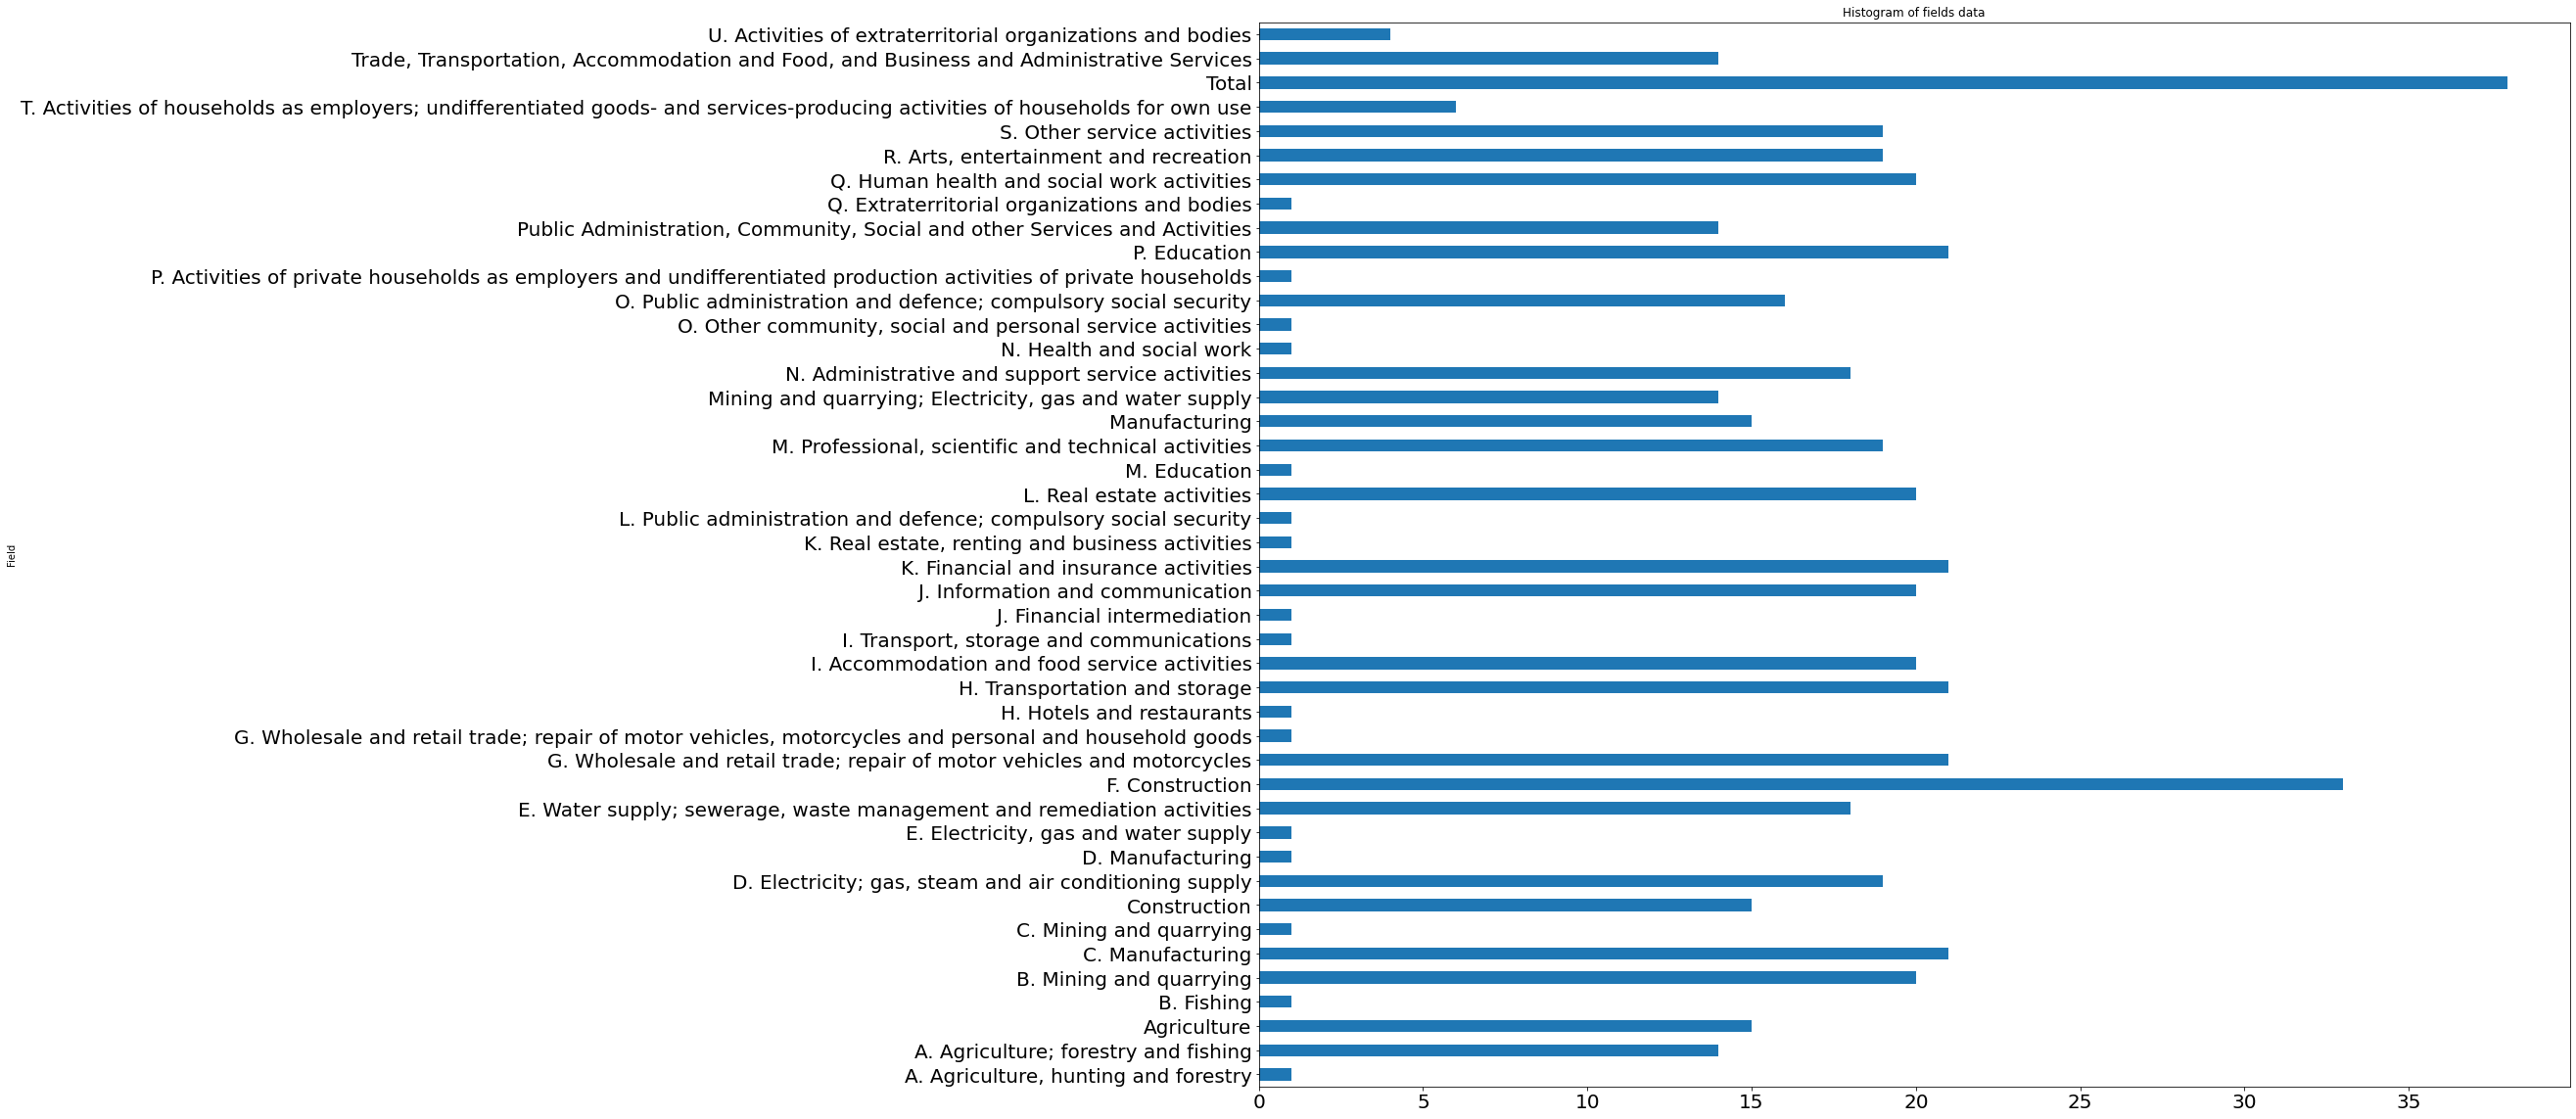

In [4]:
merged_pd.groupby(level=1).size().plot.barh(figsize=(24,20),title="Histogram of fields data",fontsize=20)

In [5]:
merged_pd.groupby(level=1).size()
# merged_pd.index.get_level_values(1).size()

Field
A. Agriculture, hunting and forestry                                                                                              1
A. Agriculture; forestry and fishing                                                                                             14
Agriculture                                                                                                                      15
B. Fishing                                                                                                                        1
B. Mining and quarrying                                                                                                          20
C. Manufacturing                                                                                                                 21
C. Mining and quarrying                                                                                                           1
Construction                                                          

## Remove rows with fields that would not be analyzed

<AxesSubplot:title={'center':'Histogram of fields data'}, ylabel='Field'>

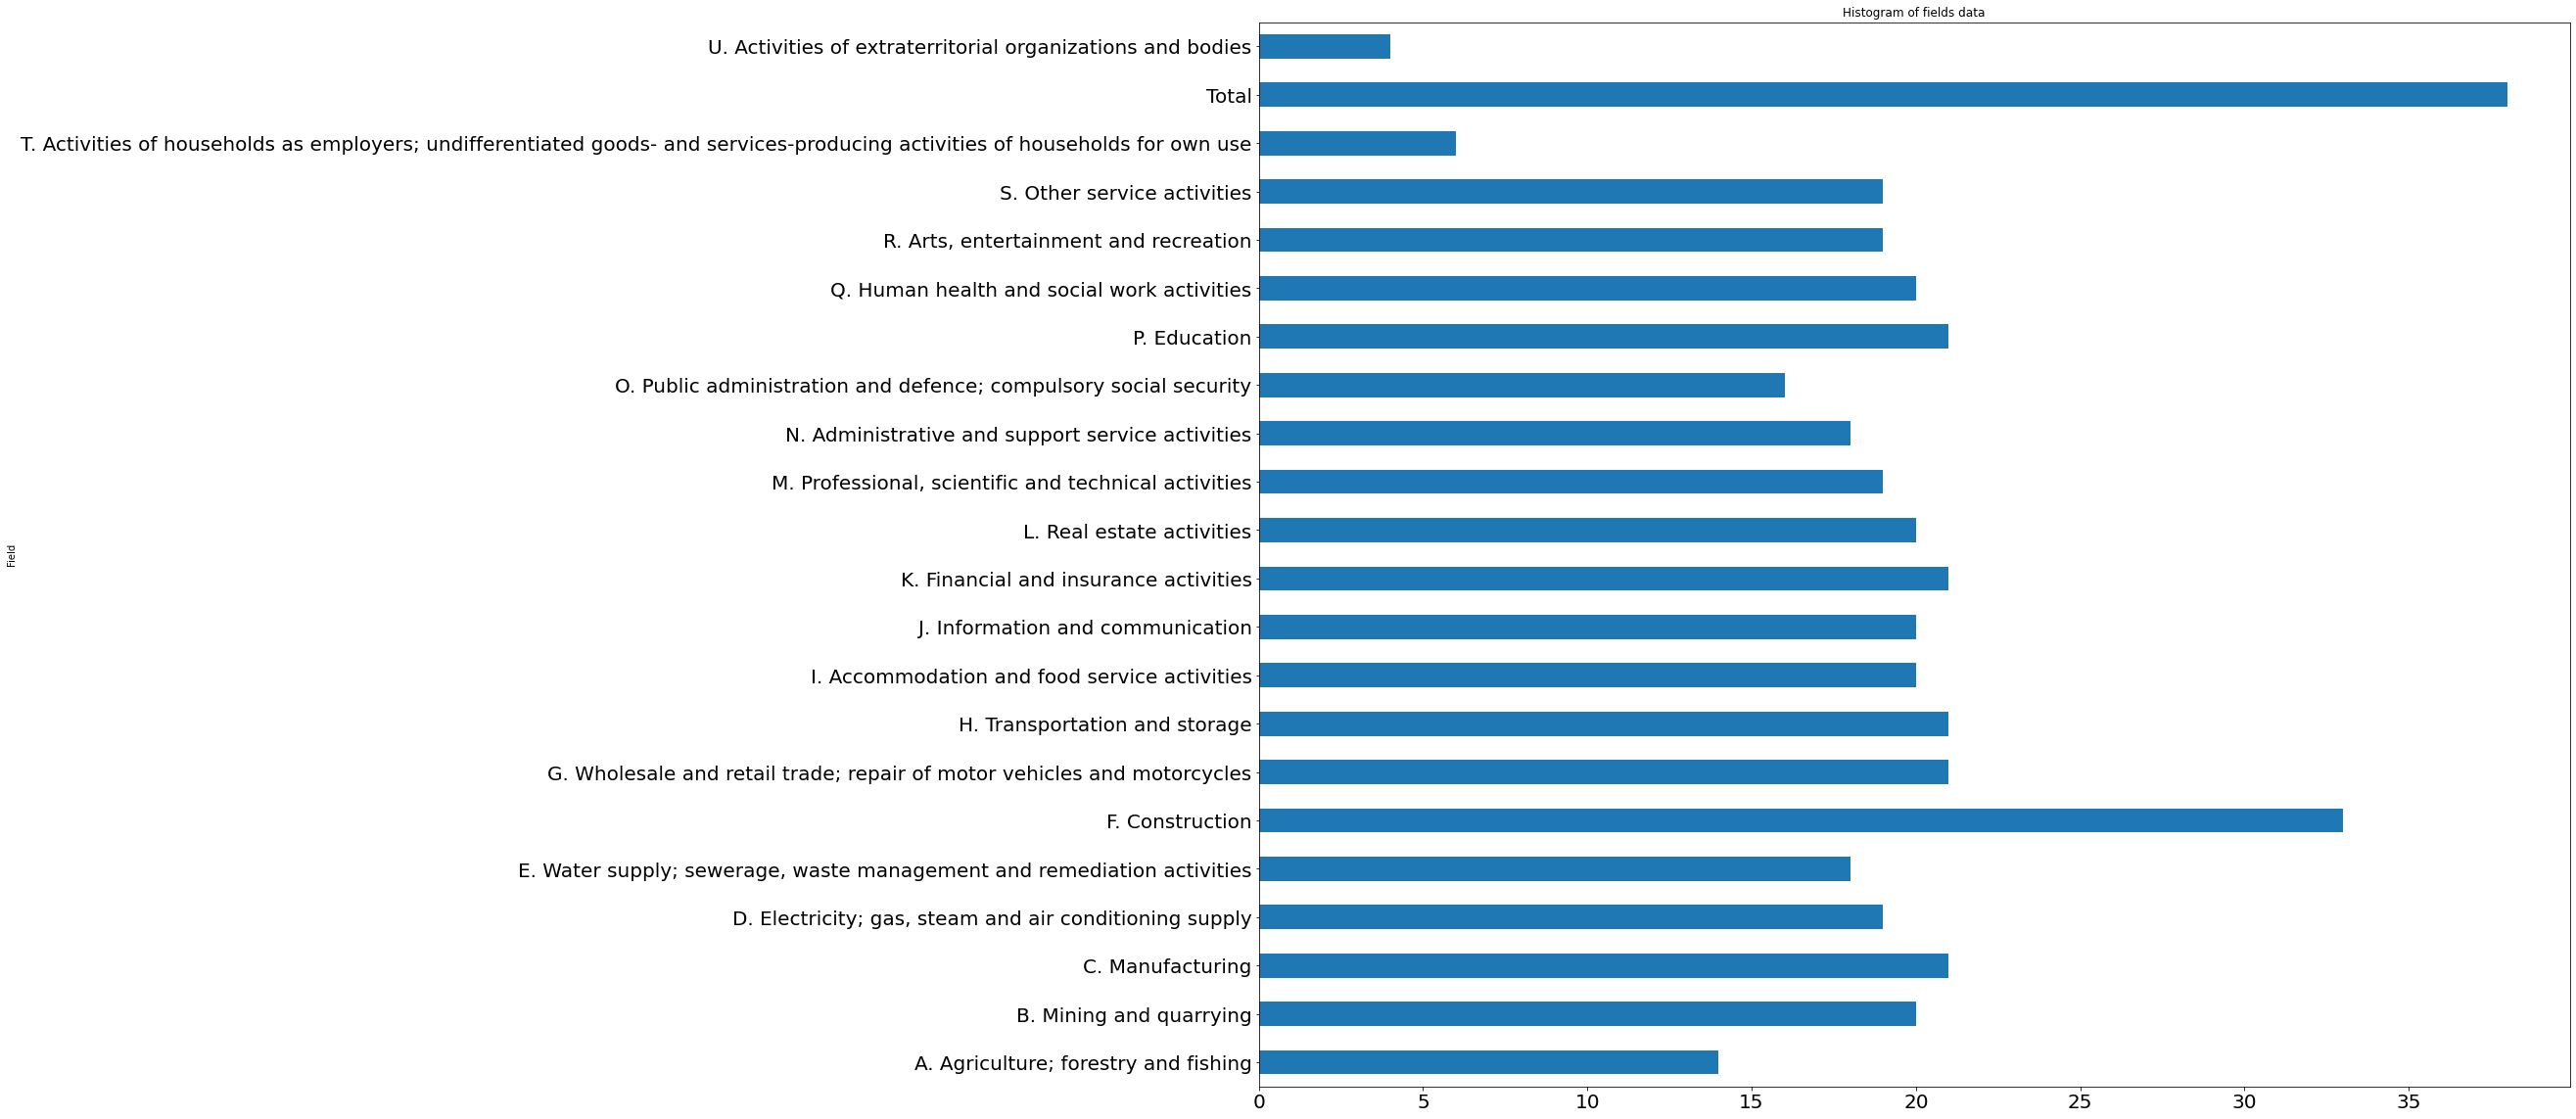

In [6]:
to_drop = [
"Construction",
"Manufacturing",
"Agriculture",
"Trade, Transportation, Accommodation and Food, and Business and Administrative Services",
"Public Administration, Community, Social and other Services and Activities",
"Mining and quarrying; Electricity, gas and water supply"
]
to_drop_statistically_different = [
    "B. Fishing",
    "E. Electricity, gas and water supply",
    "P. Activities of private households as employers and undifferentiated production activities of private households",
    "M. Education",
    "O. Other community, social and personal service activities",
    "Q. Extraterritorial organizations and bodies",
    "D. Manufacturing",
    "J. Financial intermediation",
    "G. Wholesale and retail trade; repair of motor vehicles, motorcycles and personal and household goods",
    "C. Mining and quarrying",
    "A. Agriculture, hunting and forestry",
    "K. Real estate, renting and business activities",
    "H. Hotels and restaurants",
    "I. Transport, storage and communications",
    "L. Public administration and defence; compulsory social security",
    "N. Health and social work"
]
merged_pd = merged_pd.drop(index=to_drop,level=1)
merged_pd = merged_pd.drop(index=to_drop_statistically_different,level=1)
# merged_pd = merged_pd[~merged_pd.Field.isin(to_drop_statistically_different)]
merged_pd.groupby(level=1).size().plot.barh(figsize=(24,20),title="Histogram of fields data",fontsize=20)

## Drop all countries that have no total value

In [7]:
print(merged_pd.shape)
merged_pd = merged_pd.loc[merged_pd[merged_pd.index.get_level_values(1) == "Total"].index.get_level_values(0)] # drop mexico that has only manufacturing info
print(merged_pd.shape)

(428, 10)
(427, 10)


## Analyze total "field" to narrow down possible problems

### Show all values in table

In [8]:
merged_total = merged_pd[merged_pd.index.map(lambda x: x[1]=="Total")].reset_index(level=1,drop=True)
print(merged_total.shape)
merged_total.head(50)

(38, 10)


,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
Country,,,,,,,,,,
Armenia,274.72,290.18,281.67,357.70,381.280,209.93,208.30,214.50,219.690,235.70
Austria,3379.25,3365.75,3182.42,3337.56,3727.770,2883.62,2928.87,3037.71,3268.880,3187.14
Azerbaijan,413.01,461.20,507.10,541.85,566.710,455.71,313.21,307.06,320.350,373.41
Bosnia and Herzegovina,471.49,501.31,458.74,493.00,507.310,418.74,420.61,432.34,470.300,474.54
Canada,3435.69,3662.62,3742.07,3708.02,3520.010,3125.56,3073.39,3188.65,3288.490,3316.64
Colombia,452.02,480.80,510.82,524.67,519.660,381.16,364.21,398.76,416.720,398.07
Costa Rica,713.44,774.43,865.63,948.05,904.630,987.93,935.95,911.54,52.720,929.38
Germany,3820.72,5095.95,4816.67,5038.88,4045.280,4414.75,4513.95,4687.05,5052.120,4925.69
Dominican Republic,309.91,320.96,337.89,319.94,319.410,278.81,304.99,295.91,338.170,317.05


### Show diffrence of values to look for anomalies

<AxesSubplot:title={'center':'title'}, xlabel='year', ylabel='value difference'>

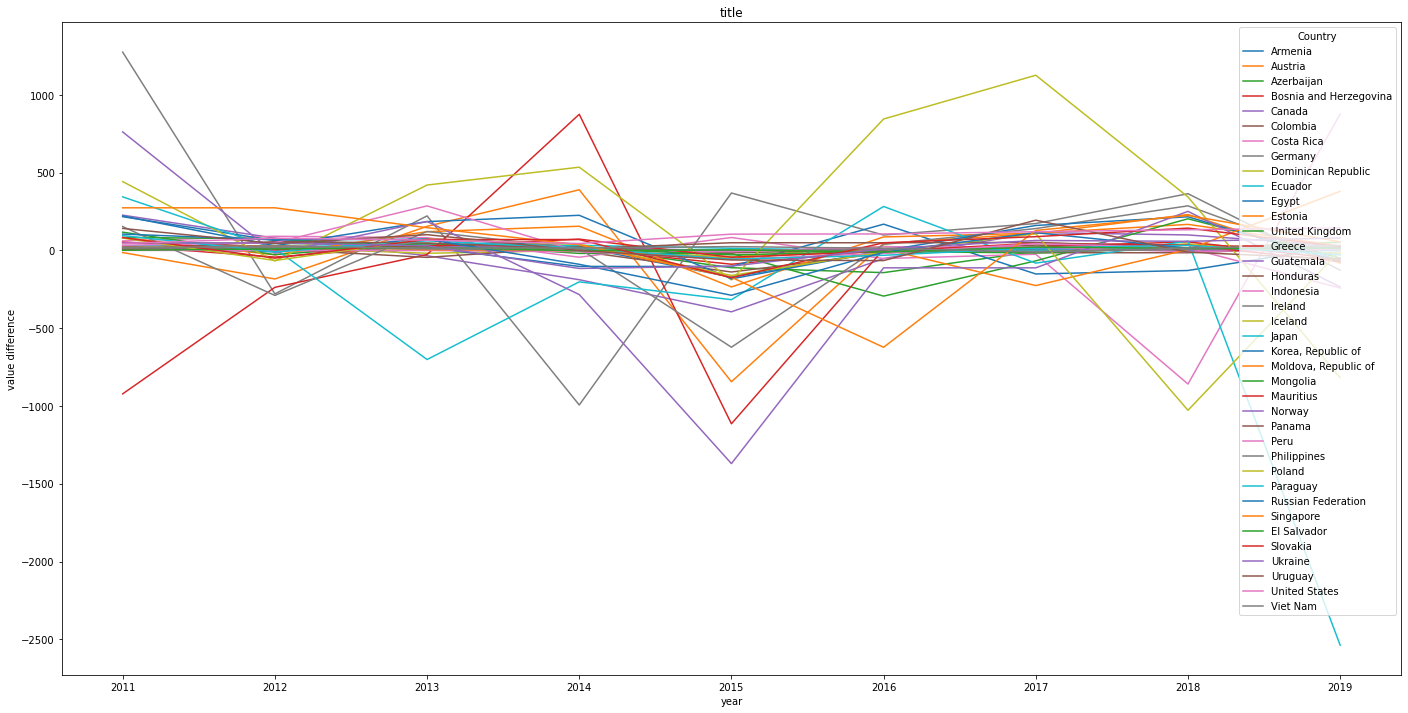

In [9]:
merged_total.T.diff().plot(figsize=(24,12),title="title",legend=True,ylabel="value difference",xlabel="year")

### Show percent change of values to look for anomalies

<AxesSubplot:title={'center':'title'}>

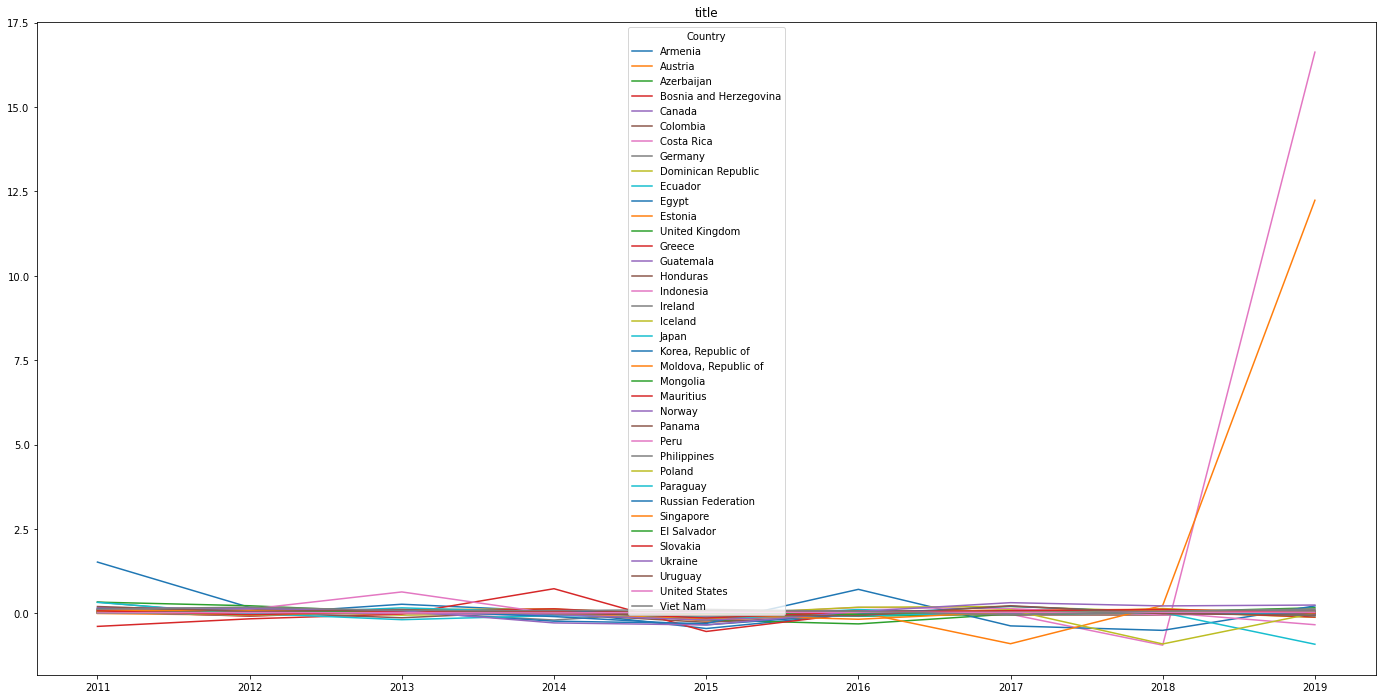

In [10]:
merged_total.T.pct_change().plot(figsize=(24,12),title="title",legend=True)

### Found anomalies:

* Costa Rica 2018

* Japan 2019

* Moldova, Republic of 2017/2018

* Poland 2018/ 2019

### Show anomalies and check if they are same for all fields

In [11]:
from IPython.display import display
display(merged_pd[merged_pd.index.get_level_values(0) == "Poland"].head())
display(merged_pd[merged_pd.index.get_level_values(0) == "Japan"].head())
display(merged_pd[merged_pd.index.get_level_values(0) == "Moldova, Republic of"].head())
display(merged_pd[merged_pd.index.get_level_values(0) == "Costa Rica"].head())

2010     2011  \
Country Field                                                                  
Poland  A. Agriculture; forestry and fishing                1095.90  1231.45   
        B. Mining and quarrying                             1929.43  2239.87   
        C. Manufacturing                                     967.46  1045.59   
        D. Electricity; gas, steam and air conditioning...  1741.81  1896.80   
        E. Water supply; sewerage, waste management and...  1070.41  1133.54   

                                                               2012     2013  \
Country Field                                                                  
Poland  A. Agriculture; forestry and fishing                1210.21  1256.24   
        B. Mining and quarrying                             1941.39  2154.29   
        C. Manufacturing                                     996.16  1071.54   
        D. Electricity; gas, steam and air conditioning...  1804.67  1972.57   
        E. Water supply; sewerage, waste management and...  1065.38  1127.89   

                                                               2014     2015  \
Country Field                                                                  
Poland  A. Agriculture; forestry and fishing                1322.80  1153.54   
        B. Mining and quarrying                             2159.02  1813.88   
        C. Manufacturing                                    1121.04   973.42   
        D. Electricity; gas, steam and air conditioning...  2014.13  1736.82   
        E. Water supply; sewerage, waste management and...  1168.13  1014.80   

                                                               2016     2017  \
Country Field                                                                  
Poland  A. Agriculture; forestry and fishing                1139.70  1216.49   
        B. Mining and quarrying                             1733.10  1858.10   
        C. Manufacturing                                     971.94  1086.95   
        D. Electricity; gas, steam and air conditioning...  1716.16  1856.16   
        E. Water supply; sewerage, waste management and...  1005.19  1088.48   

                                                              2018    2019  
Country Field                                                               
Poland  A. Agriculture; forestry and fishing                112.96  111.64  
        B. Mining and quarrying                             179.35  180.22  
        C. Manufacturing                                    101.68  102.30  
        D. Electricity; gas, steam and air conditioning...  171.28  169.05  
        E. Water supply; sewerage, waste management and...   99.79   99.41

2010     2011  \
Country Field                                                                  
Japan   B. Mining and quarrying                             3556.62  3792.90   
        F. Construction                                     3512.19  3925.72   
        G. Wholesale and retail trade; repair of motor ...  3391.44  3621.24   
        H. Transportation and storage                       2979.04  3230.29   
        I. Accommodation and food service activities        2697.66  2967.16   

                                                               2012     2013  \
Country Field                                                                  
Japan   B. Mining and quarrying                             3912.75  3195.84   
        F. Construction                                     3898.96  3248.10   
        G. Wholesale and retail trade; repair of motor ...  3714.73  3005.26   
        H. Transportation and storage                       3288.61  2648.68   
        I. Accommodation and food service activities        2947.72  2383.30   

                                                               2014     2015  \
Country Field                                                                  
Japan   B. Mining and quarrying                             2914.73  2551.96   
        F. Construction                                     3017.61  2709.76   
        G. Wholesale and retail trade; repair of motor ...  2880.75  2520.57   
        H. Transportation and storage                       2527.73  2209.94   
        I. Accommodation and food service activities        2285.15  1990.18   

                                                               2016     2017  \
Country Field                                                                  
Japan   B. Mining and quarrying                             2985.49  2864.50   
        F. Construction                                     3075.57  2946.52   
        G. Wholesale and retail trade; repair of motor ...  2830.15  2745.93   
        H. Transportation and storage                       2546.12  2449.94   
        I. Accommodation and food service activities        2219.81  2158.41   

                                                               2018    2019  
Country Field                                                                
Japan   B. Mining and quarrying                             3016.58  250.21  
        F. Construction                                     3031.07  254.41  
        G. Wholesale and retail trade; repair of motor ...  2800.14  241.34  
        H. Transportation and storage                       2542.94  213.90  
        I. Accommodation and food service activities        2221.45  189.43

2010    2011     2012    2013    2014  \
Country              Field                                                      
Moldova, Republic of F. Construction  262.59  246.13  274.905  303.68  296.79   
                     Total            240.25  259.14  287.140  291.91  291.38   

                                        2015    2016   2017   2018    2019  
Country              Field                                                  
Moldova, Republic of F. Construction  232.65  243.09  24.98  30.74  407.16  
                     Total            241.17  250.85  25.17  31.09  411.63

,,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
Country,Field,,,,,,,,,,
Costa Rica,Total,713.44,774.43,865.63,948.05,904.63,987.93,935.95,911.54,52.72,929.38


### Fix anomalies

In [12]:
for Country,Field in merged_pd.index:
    index = (Country,Field)
    if Country=='Poland':
        if merged_pd.loc[index,'2018']<200:
            merged_pd.loc[index,'2018'] = merged_pd.loc[index,'2018']*10
        if merged_pd.loc[index,'2019']<200:
            merged_pd.loc[index,'2019'] = merged_pd.loc[index,'2019']*10
    elif Country=='Japan':
        if merged_pd.loc[index,'2019']<300:
            merged_pd.loc[index,'2019'] = merged_pd.loc[index,'2019']*10
    elif Country=='Moldova, Republic of':
        if merged_pd.loc[index,'2017']<50:
            merged_pd.loc[index,'2017'] = merged_pd.loc[index,'2017']*10
        if merged_pd.loc[index,'2018']<50:
            merged_pd.loc[index,'2018'] = merged_pd.loc[index,'2018']*10
    elif Country=='Costa Rica':
        if merged_pd.loc[index,'2018']<100:
            merged_pd.loc[index,'2018'] = merged_pd.loc[index,'2018']*10
display(merged_pd[merged_pd.index.get_level_values(0) == "Poland"].head())
display(merged_pd[merged_pd.index.get_level_values(0) == "Japan"].head())
display(merged_pd[merged_pd.index.get_level_values(0) == "Moldova, Republic of"].head())
display(merged_pd[merged_pd.index.get_level_values(0) == "Costa Rica"].head())

2010     2011  \
Country Field                                                                  
Poland  A. Agriculture; forestry and fishing                1095.90  1231.45   
        B. Mining and quarrying                             1929.43  2239.87   
        C. Manufacturing                                     967.46  1045.59   
        D. Electricity; gas, steam and air conditioning...  1741.81  1896.80   
        E. Water supply; sewerage, waste management and...  1070.41  1133.54   

                                                               2012     2013  \
Country Field                                                                  
Poland  A. Agriculture; forestry and fishing                1210.21  1256.24   
        B. Mining and quarrying                             1941.39  2154.29   
        C. Manufacturing                                     996.16  1071.54   
        D. Electricity; gas, steam and air conditioning...  1804.67  1972.57   
        E. Water supply; sewerage, waste management and...  1065.38  1127.89   

                                                               2014     2015  \
Country Field                                                                  
Poland  A. Agriculture; forestry and fishing                1322.80  1153.54   
        B. Mining and quarrying                             2159.02  1813.88   
        C. Manufacturing                                    1121.04   973.42   
        D. Electricity; gas, steam and air conditioning...  2014.13  1736.82   
        E. Water supply; sewerage, waste management and...  1168.13  1014.80   

                                                               2016     2017  \
Country Field                                                                  
Poland  A. Agriculture; forestry and fishing                1139.70  1216.49   
        B. Mining and quarrying                             1733.10  1858.10   
        C. Manufacturing                                     971.94  1086.95   
        D. Electricity; gas, steam and air conditioning...  1716.16  1856.16   
        E. Water supply; sewerage, waste management and...  1005.19  1088.48   

                                                              2018    2019  
Country Field                                                               
Poland  A. Agriculture; forestry and fishing                1129.6  1116.4  
        B. Mining and quarrying                             1793.5  1802.2  
        C. Manufacturing                                    1016.8  1023.0  
        D. Electricity; gas, steam and air conditioning...  1712.8  1690.5  
        E. Water supply; sewerage, waste management and...   997.9   994.1

2010     2011  \
Country Field                                                                  
Japan   B. Mining and quarrying                             3556.62  3792.90   
        F. Construction                                     3512.19  3925.72   
        G. Wholesale and retail trade; repair of motor ...  3391.44  3621.24   
        H. Transportation and storage                       2979.04  3230.29   
        I. Accommodation and food service activities        2697.66  2967.16   

                                                               2012     2013  \
Country Field                                                                  
Japan   B. Mining and quarrying                             3912.75  3195.84   
        F. Construction                                     3898.96  3248.10   
        G. Wholesale and retail trade; repair of motor ...  3714.73  3005.26   
        H. Transportation and storage                       3288.61  2648.68   
        I. Accommodation and food service activities        2947.72  2383.30   

                                                               2014     2015  \
Country Field                                                                  
Japan   B. Mining and quarrying                             2914.73  2551.96   
        F. Construction                                     3017.61  2709.76   
        G. Wholesale and retail trade; repair of motor ...  2880.75  2520.57   
        H. Transportation and storage                       2527.73  2209.94   
        I. Accommodation and food service activities        2285.15  1990.18   

                                                               2016     2017  \
Country Field                                                                  
Japan   B. Mining and quarrying                             2985.49  2864.50   
        F. Construction                                     3075.57  2946.52   
        G. Wholesale and retail trade; repair of motor ...  2830.15  2745.93   
        H. Transportation and storage                       2546.12  2449.94   
        I. Accommodation and food service activities        2219.81  2158.41   

                                                               2018    2019  
Country Field                                                                
Japan   B. Mining and quarrying                             3016.58  2502.1  
        F. Construction                                     3031.07  2544.1  
        G. Wholesale and retail trade; repair of motor ...  2800.14  2413.4  
        H. Transportation and storage                       2542.94  2139.0  
        I. Accommodation and food service activities        2221.45  1894.3

2010    2011     2012    2013    2014  \
Country              Field                                                      
Moldova, Republic of F. Construction  262.59  246.13  274.905  303.68  296.79   
                     Total            240.25  259.14  287.140  291.91  291.38   

                                        2015    2016   2017   2018    2019  
Country              Field                                                  
Moldova, Republic of F. Construction  232.65  243.09  249.8  307.4  407.16  
                     Total            241.17  250.85  251.7  310.9  411.63

,,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
Country,Field,,,,,,,,,,
Costa Rica,Total,713.44,774.43,865.63,948.05,904.63,987.93,935.95,911.54,527.2,929.38


## Check plots for new anomalies

### Recreate dataframe to applay

<AxesSubplot:title={'center':'title'}, xlabel='year', ylabel='value difference'>

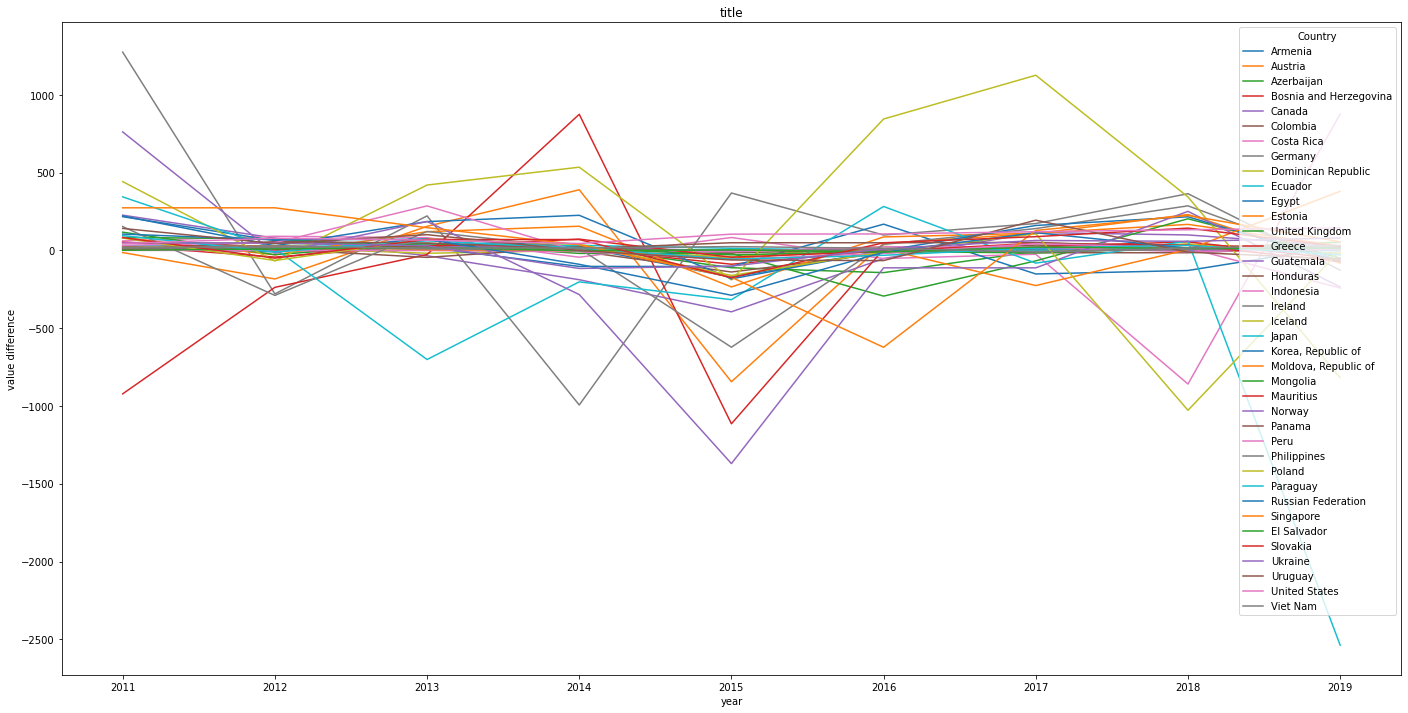

In [13]:
merged_total.T.diff().plot(figsize=(24,12),title="title",legend=True,ylabel="value difference",xlabel="year")

<AxesSubplot:title={'center':'title'}>

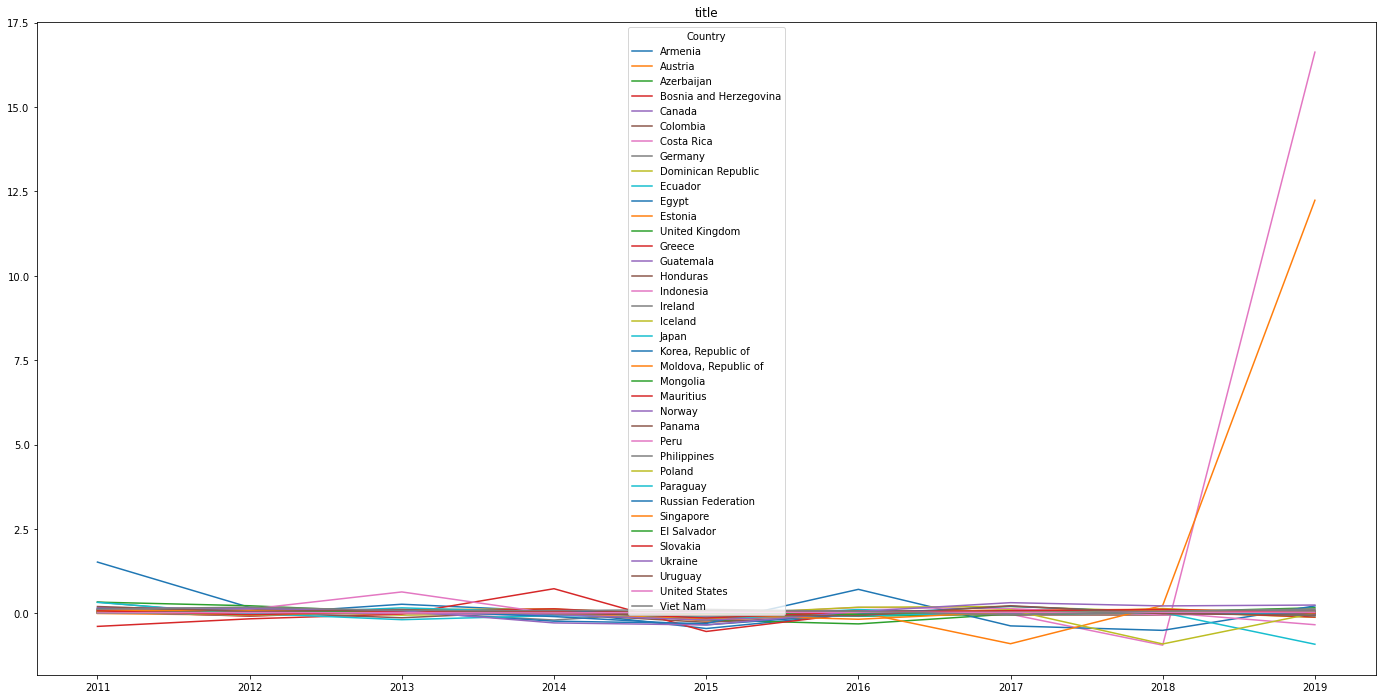

In [14]:
merged_total.T.pct_change().plot(figsize=(24,12),title="title",legend=True)

### Conclusions

* values that rapidly change on diffrence plot are for highly developed countries, where high value change is relativly low percent change

* values on percent change plot are in reasonable boundaries

## Analyze fields data

### Analyze plots for anomalies

<AxesSubplot:title={'center':'title'}>

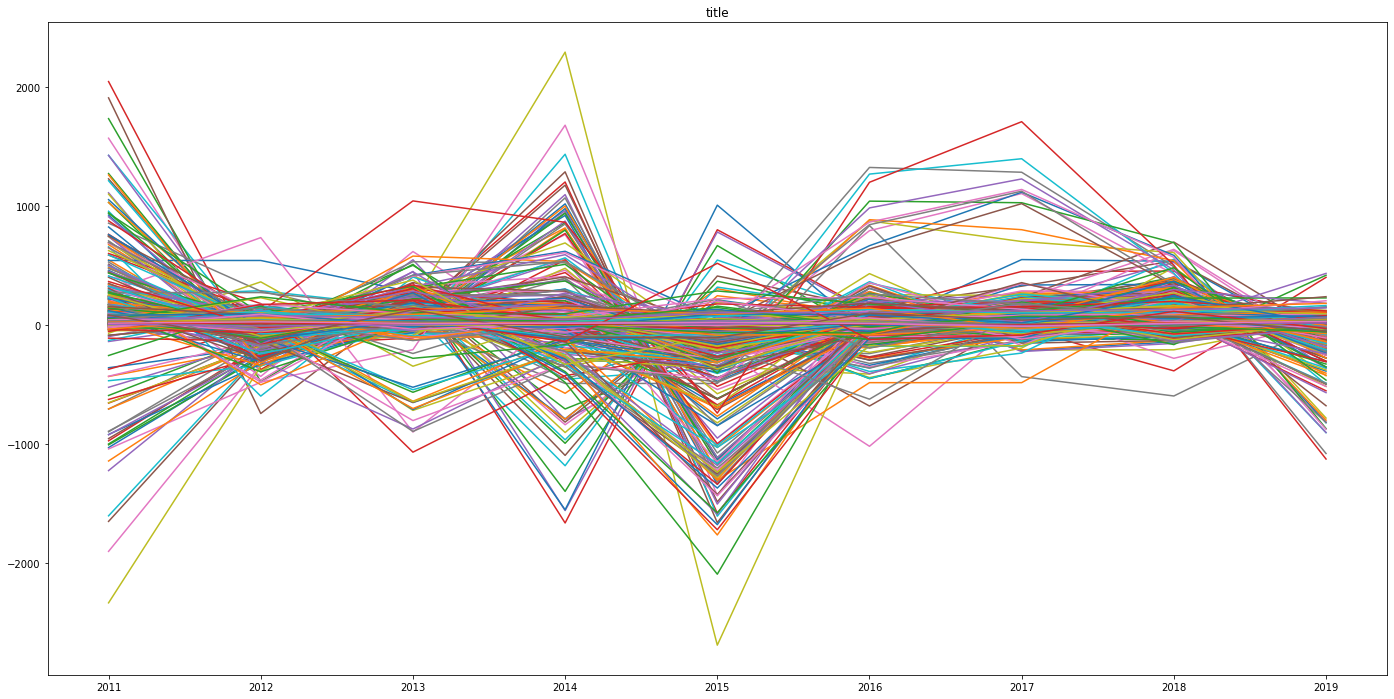

In [15]:
merged_pd.T.diff().plot(figsize=(24,12),title="title",legend=False)

<AxesSubplot:title={'center':'title'}>

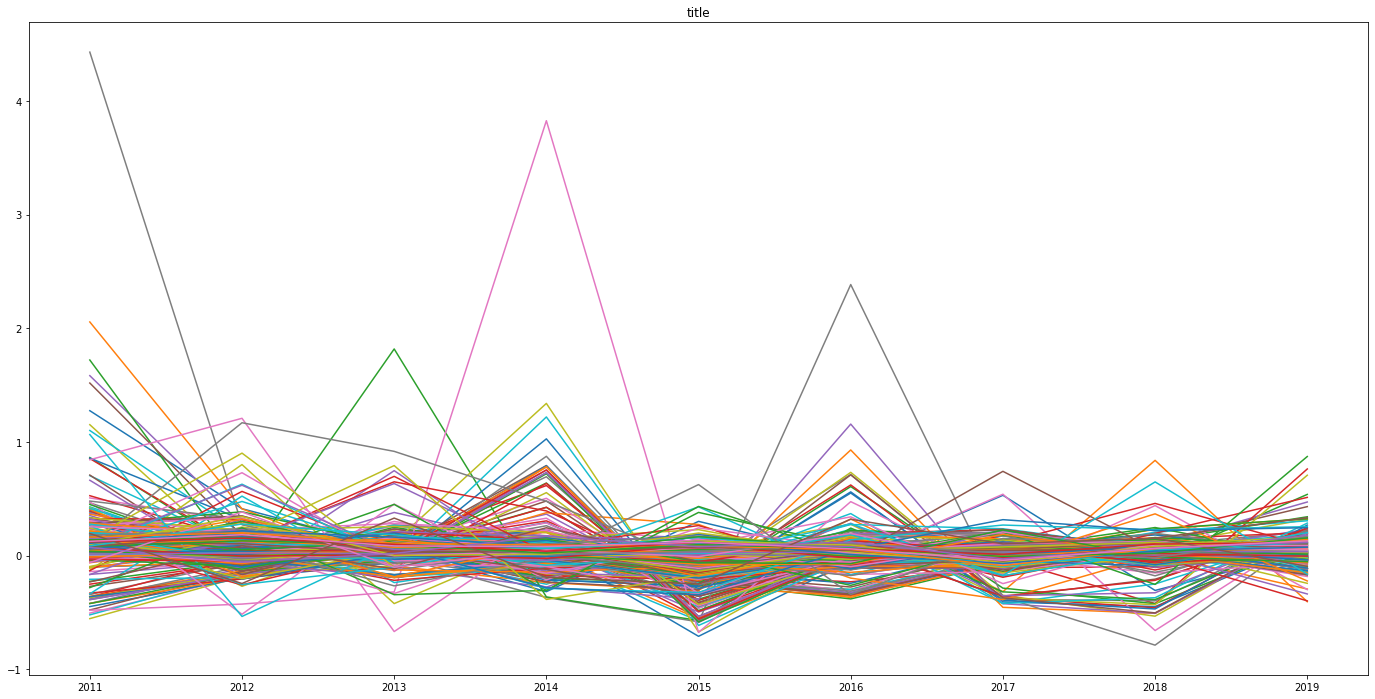

In [16]:
merged_pd.T.pct_change().plot(figsize=(24,12),title="title",legend=False)

### Check high percent changes

In [17]:
set_option('display.max_rows', None)
data = merged_pd.T.pct_change().max().nlargest(10)
display(data)

Country    Field                                                                 
Egypt      K. Financial and insurance activities                                     4.431345
Greece     L. Real estate activities                                                 3.827899
Egypt      E. Water supply; sewerage, waste management and remediation activities    2.056648
           Q. Human health and social work activities                                1.819042
           H. Transportation and storage                                             1.584007
           Total                                                                     1.519102
Greece     D. Electricity; gas, steam and air conditioning supply                    1.339906
Egypt      D. Electricity; gas, steam and air conditioning supply                    1.275722
Greece     E. Water supply; sewerage, waste management and remediation activities    1.220636
Guatemala  B. Mining and quarrying                                      

In [18]:
merged_pd[merged_pd.index.isin(data.index)]

2010  \
Country   Field                                                         
Egypt     D. Electricity; gas, steam and air conditioning...   172.13   
          E. Water supply; sewerage, waste management and...   114.92   
          H. Transportation and storage                        184.21   
          K. Financial and insurance activities                193.65   
          Q. Human health and social work activities           112.46   
          Total                                                142.92   
Greece    D. Electricity; gas, steam and air conditioning...  4214.45   
          E. Water supply; sewerage, waste management and...  3076.99   
          L. Real estate activities                           2166.22   
Guatemala B. Mining and quarrying                              330.34   

                                                                 2011  \
Country   Field                                                         
Egypt     D. Electricity; gas, steam and air conditioning...   391.72   
          E. Water supply; sewerage, waste management and...   351.27   
          H. Transportation and storage                        476.00   
          K. Financial and insurance activities               1051.78   
          Q. Human health and social work activities           306.09   
          Total                                                360.03   
Greece    D. Electricity; gas, steam and air conditioning...  1878.79   
          E. Water supply; sewerage, waste management and...  1473.45   
          L. Real estate activities                           1125.13   
Guatemala B. Mining and quarrying                              609.11   

                                                                 2012  \
Country   Field                                                         
Egypt     D. Electricity; gas, steam and air conditioning...   553.50   
          E. Water supply; sewerage, waste management and...   496.03   
          H. Transportation and storage                        607.66   
          K. Financial and insurance activities               1337.50   
          Q. Human health and social work activities           276.75   
          Total                                                423.38   
Greece    D. Electricity; gas, steam and air conditioning...  1533.82   
          E. Water supply; sewerage, waste management and...  1244.12   
          L. Real estate activities                            645.57   
Guatemala B. Mining and quarrying                             1345.40   

                                                                 2013  \
Country   Field                                                         
Egypt     D. Electricity; gas, steam and air conditioning...   588.04   
          E. Water supply; sewerage, waste management and...   450.05   
          H. Transportation and storage                        545.53   
          K. Financial and insurance activities               1331.52   
          Q. Human health and social work activities           780.17   
          Total                                                443.06   
Greece    D. Electricity; gas, steam and air conditioning...  1714.06   
          E. Water supply; sewerage, waste management and...  1177.96   
          L. Real estate activities                            439.45   
Guatemala B. Mining and quarrying                              446.64   

                                                                  2014  \
Country   Field                                                          
Egypt     D. Electricity; gas, steam and air conditioning...   462.780   
          E. Water supply; sewerage, waste management and...   343.620   
          H. Transportation and storage                        394.360   
          K. Financial and insurance activities                841.350   
          Q. Human health and social work activities           496.795   
          Total                        

### Conclusions

* High percentage changes for Egypt and Greece are explainable economically 

* Other changes are in reasonable bounds

In [19]:
merged_pd.to_csv("dataset//earnings_split.csv")